In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Haveing completed the data management and restructuring process, the next step is to actually define and train the LS-SVM model.
Following the indications of the paper the signal will be computed based on the following function:
$$ y_{t} = LS - SVM(r_{t-1}, EMA_{10t-1}, MACD_{t-1}) $$
Meaning that the 10 lag EMA, the MACD and the Logaritmic return, at time t-1, will be the relevant features onto which the model is going to be trained

In [2]:
# Load your dataset
df = pd.read_csv('../data/BELEX15_.csv')

# Create a y column for the training part
df['y'] = df['price'].pct_change().shift(-1) > 0

# Shift the feature columns to use t-1 metrics
df[['MACD', 'EMA_10', 'Log_Return']] = df[['MACD', 'EMA_10', 'Log_Return']].shift(1)

# Drop the first row as it will have NaN values after shifting
df = df.dropna()

# Select relevant features
X = df[['MACD', 'EMA_10', 'Log_Return']]
y = df['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the LS-SVM model
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.83%


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3270 entries, 2 to 3271
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        3270 non-null   object 
 1   price       3270 non-null   float64
 2   MACD        3270 non-null   float64
 3   EMA_10      3270 non-null   float64
 4   Log_Return  3270 non-null   float64
 5   y           3270 non-null   bool   
dtypes: bool(1), float64(4), object(1)
memory usage: 156.5+ KB


In [4]:
from trading_signal import compute_trading_signal

In [5]:
compute_trading_signal(df)

,date,price,MACD,EMA_10,Log_Return,y,trading_signal
2,2010-01-13,680.78,0.000000,676.170000,0.022679,True,0
3,2010-01-14,683.71,1.237265,678.990000,-0.015884,True,0
4,2010-01-15,688.32,1.323017,679.315455,0.004295,False,-1
5,2010-01-18,687.54,1.608856,680.114463,0.006720,False,0
6,2010-01-19,684.51,2.182219,681.606379,-0.001134,True,1
...,...,...,...,...,...,...,...
3267,2022-12-23,808.73,0.574644,810.214786,0.002876,True,1
3268,2022-12-26,809.51,0.610939,810.403007,-0.003111,True,0
3269,2022-12-27,809.77,0.431388,810.098824,0.000964,True,0
3270,2022-12-28,811.27,0.348020,809.991765,0.000321,True,0


In [6]:
df.head(50)

,date,price,MACD,EMA_10,Log_Return,y,trading_signal
2,2010-01-13,680.78,0.000000,676.170000,0.022679,True,0
3,2010-01-14,683.71,1.237265,678.990000,-0.015884,True,0
4,2010-01-15,688.32,1.323017,679.315455,0.004295,False,-1
5,2010-01-18,687.54,1.608856,680.114463,0.006720,False,0
6,2010-01-19,684.51,2.182219,681.606379,-0.001134,True,1
7,2010-01-20,685.12,2.544344,682.685219,-0.004417,False,-1
8,2010-01-21,682.89,2.557356,683.016997,0.000891,True,1
9,2010-01-22,683.34,2.587067,683.399361,-0.003260,False,-1
10,2010-01-25,681.69,2.402971,683.306750,0.000659,False,0
11,2010-01-26,679.36,2.267250,683.312796,-0.002418,True,1


In [7]:
from compute_return import calculate_cumulative_return, calculate_returns

In [8]:
# Example usage:
# Assuming 'data' is your pandas DataFrame with 'trading_signal', 'price', and 'date' columns
# and 'start_date' and 'end_date' are the desired date range.

start_date = '2020-01-02'
end_date = '2022-01-04'

cumulative_return = calculate_cumulative_return(df, start_date, end_date)
print(f"Cumulative Return from {start_date} to {end_date}: {cumulative_return:.2f}%")

Cumulative Return from 2020-01-02 to 2022-01-04: 59.37%


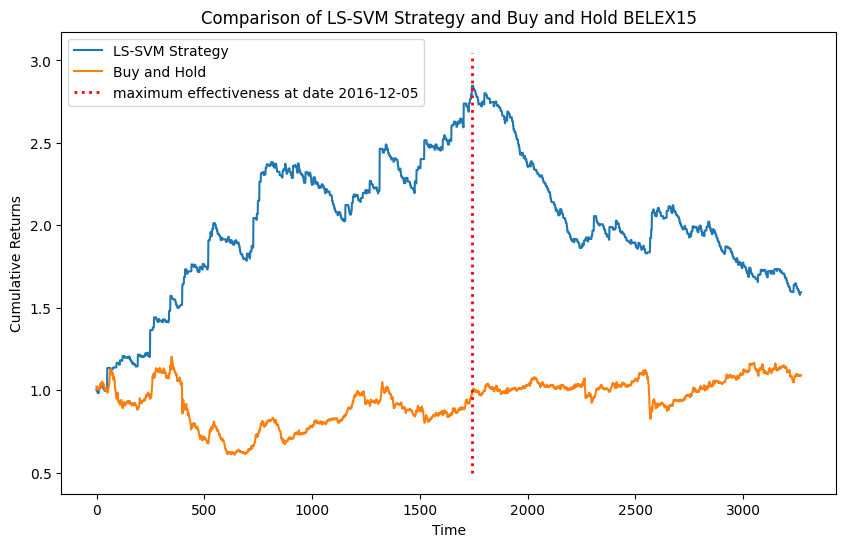

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from LS_SVM import plotDF

df = df.sort_values(by='date').reset_index(drop=True)

df['ls_svm_cumulative_returns'] = 0
df['ls_svm_return'] = 0
df.at[0, 'trading_signal'] = 1

for index, row in df.iterrows():
    if df.at[index, 'trading_signal'] == 1:
        start_date = df.at[index, 'date']
        for i in range(index, len(df)):
            if df.at[i, 'trading_signal'] == -1:
                end_date = df.at[i, 'date']
                break
        trade_return = calculate_returns(df, start_date, end_date)
        if index != 0:
            # Call calculate_returns method to get the return for the current trade
            df.at[index, 'ls_svm_cumulative_returns'] = df.at[index-1, 'ls_svm_cumulative_returns'] * (1 + trade_return / 100)
        else:
            df.at[index, 'ls_svm_cumulative_returns'] = 1 * (1 + trade_return / 100)
        df.at[index, 'ls_svm_return'] = trade_return
    else:
        if index == 0:
            df.at[index, 'ls_svm_cumulative_returns'] = 0
        else:
            df.at[index, 'ls_svm_cumulative_returns'] = df.at[index-1, 'ls_svm_cumulative_returns']

# Simulate buy-and-hold strategy
df['buy_and_hold_returns'] = df['Log_Return']
df['buy_and_hold_cumulative_returns'] = (1 + df['buy_and_hold_returns']).cumprod()

plotDF(df)

# df.to_csv('../DF.csv', sep=';', decimal=',')

Accuracy: 51.62%
Cumulative Return from 2022-12-23 to 2022-12-29: -1.78%


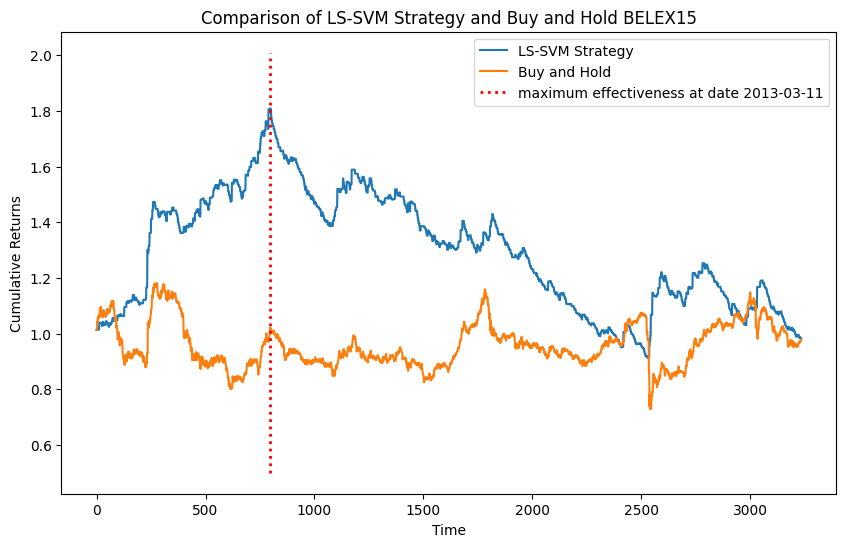

Accuracy: 50.00%
Cumulative Return from 2022-12-23 to 2022-12-29: 268.41%


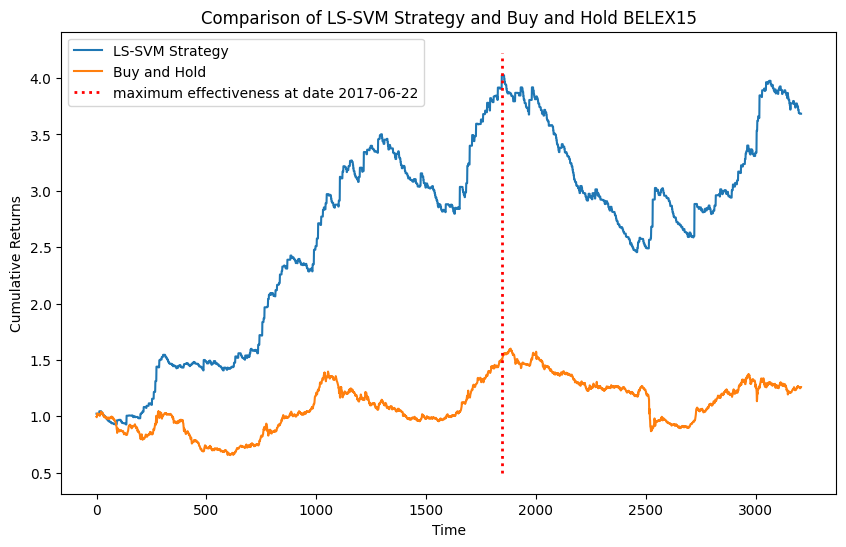

Accuracy: 53.67%
Cumulative Return from 2022-12-23 to 2022-12-29: 7025.83%


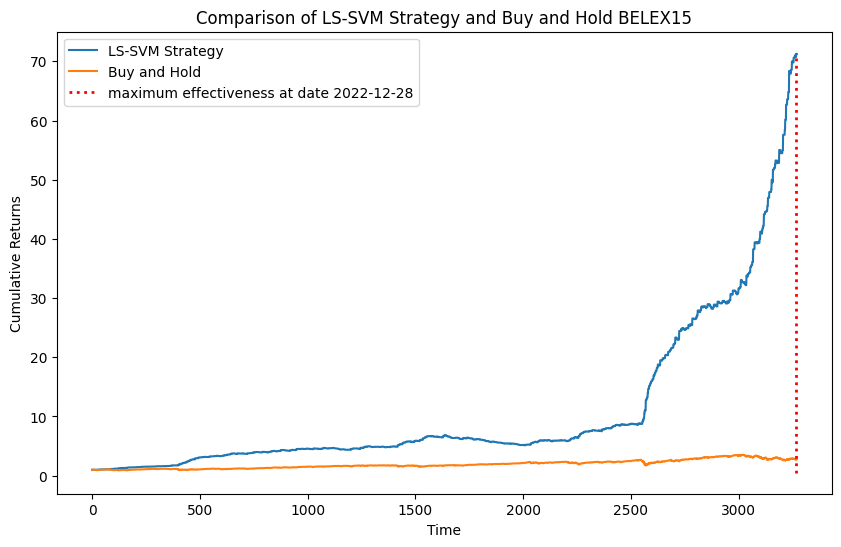

Accuracy: 51.22%
Cumulative Return from 2022-12-23 to 2022-12-29: 419766.12%


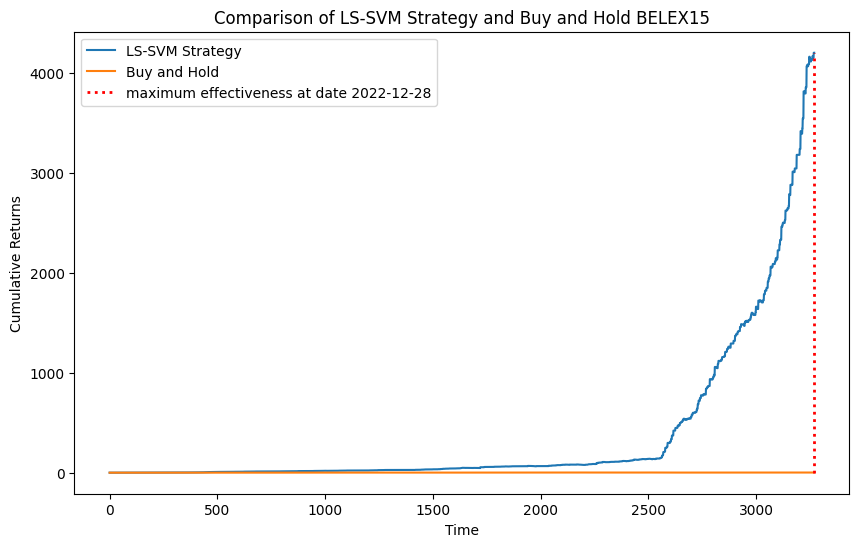

In [13]:
from LS_SVM import plotDF, getCBX10_Df, getSOFIX_Df, getSP500_Df, getSP600_Df

Belex15_df = df
Belex15_cumulative_return = cumulative_return

#repplicate on other indexes
Cbx10_df = getCBX10_Df(start_date, end_date)
Cbx10_cumulative_return = calculate_cumulative_return(Cbx10_df, start_date, end_date)
plotDF(Cbx10_df)

SOFIX_df = getSOFIX_Df(start_date, end_date)
SOFIX_cumulative_return = calculate_cumulative_return(SOFIX_df, start_date, end_date)
plotDF(SOFIX_df)

SP500_df = getSP500_Df(start_date, end_date)
SP500_cumulative_return = calculate_cumulative_return(SP500_df, start_date, end_date)
plotDF(SP500_df)

SP600_df = getSP600_Df(start_date, end_date)
SP600_cumulative_return = calculate_cumulative_return(SP600_df, start_date, end_date)
plotDF(SP600_df)

SP600_df.to_csv('../DF.csv', sep=';', decimal=',')

#  Results

In [11]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["BELEX15", 0, 1], 
    ["CBX10", 1, 2], 
    ["SOFIX", 2, 4], 
    ["S&P500", 3, 4],
    ["S&P600", 3, 5]
]
 
# create header
head = ["Index", "Buy and Hold", "LS-SVM"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+---------+----------------+----------+
| Index   |   Buy and Hold |   LS-SVM |
+=========+================+==========+
| BELEX15 |              0 |        1 |
+---------+----------------+----------+
| CBX10   |              1 |        2 |
+---------+----------------+----------+
| SOFIX   |              2 |        4 |
+---------+----------------+----------+
| S&P500  |              3 |        4 |
+---------+----------------+----------+
| S&P600  |              3 |        5 |
+---------+----------------+----------+
